In [1]:
import pandas as pd
import numpy as np
import pandas_datareader.data as pd_reader
import backtrader as bt
import backtrader.indicators as btind
import backtrader.feeds as btfeeds
import datetime
import math
import os 
from tqdm import tqdm 

%matplotlib inline

In [2]:
## Feed Data into backtrader
# ticker1 = 'AAL'
# aal = pd.read_csv(f".\\bt_stock_data\{ticker1}.csv", index_col=0, parse_dates=True)
# aal_feed = bt.feeds.PandasData(dataname=aal, openinterest=-1)

In [36]:
## Startegy
initial_cap = 1000000
class BuyAndHoldStrategy(bt.Strategy):
    
    def __init__(self):
        self.pending_orders = dict()
        
    def notify_order(self, order):
        if not order is None:
            if order.status == order.Completed:
                symbol = self.pending_orders[order.ref]
                print('%s: %s order filled' % (self.datetime.date(), symbol))
            
    #! this line of code is part of solution described above
    def prenext(self):
        self.next()
    
    def start(self):
        self.order = None  # sentinel to avoid operrations on pending order

    def next(self):
        for i, d in enumerate(self.datas):
            #! this line of code is part of solution described above
            #! check if instrument is available for trading

            can_trade =  self.datetime.date() in self.datas[i]._dataname.index 
            no_position = not self.getposition(self.datas[i])

            if can_trade:
                ta = self.datas[i]._dataname['transactionAmounts'].loc[self.datetime.date()]
                rta = self.datas[i]._dataname['rank_transactionAmounts'].loc[self.datetime.date()]
                sdrta = self.datas[i]._dataname['sum_decen_rank_transactionAmounts'].loc[self.datetime.date()]
                tn = self.datas[i]._dataname['numTransactions'].loc[self.datetime.date()]
                if ~np.isnan(ta) and ~np.isnan(tn) and ~np.isinf(ta) and ~np.isinf(tn):
                    if (tn > 1):
                        volume = self.datas[i]._dataname['volume'].loc[self.datetime.date()]
                        prc = self.datas[i]._dataname['close'].loc[self.datetime.date()]
                        # we want to allocate $20000 in each instrument, but as order will
                        # be executed only at the next days's open price, we leave a margin of $1000
                        # to make sure that order will not be cancelled due to lack of cash
                        if ta < 0:
                            order = self.order_target_value(data=self.datas[i], target= np.sign(rta-0.5) * initial_cap/sdrta * np.abs(rta-0.5))
                            if not order is None:
                                self.pending_orders[order.ref] = d._name

                    print('%s: %s order submitted' % (self.datetime.date(), d._name))      


In [37]:
df0 = pd.read_csv(f"./bt_stock_data1/AAL.csv", index_col=0)
bad_tickers = []
for file in tqdm(os.listdir("./bt_stock_data1/")):
       df = pd.read_csv(f"./bt_stock_data1/{file}", index_col=0)
       if len(df.index) != len(df0.index):
              bad_tickers.append(file[:-4])

100%|██████████| 307/307 [00:01<00:00, 216.50it/s]


In [38]:
## Initialize backtesting   
cerebro = bt.Cerebro(stdstats=False)
cnt = 0
for file in tqdm(os.listdir("./bt_stock_data1/")):
    ticker = file[:-4]
    df_feed = pd.read_csv(f".\\bt_stock_data1\{ticker}.csv", index_col=0, parse_dates=True)
    if df_feed.shape[0] > 0 and (df_feed.shape[0] == len(df_feed.index.unique())):
        if ticker in ['CRM', 'TECH', 'DLTR', 'V']:
            continue
        if ticker in bad_tickers:
            continue
        cerebro.adddata(bt.feeds.PandasData(dataname=df_feed, openinterest=-1), name=ticker)
        cnt += 1
print("validnum: ", cnt)
cerebro.broker.setcash(10000*cnt)
cerebro.addstrategy(BuyAndHoldStrategy)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

strats = cerebro.run()
# cplots = cerebro.plot()

100%|██████████| 307/307 [00:01<00:00, 188.34it/s]


validnum:  304
2018-01-02: ABC order submitted
2018-01-02: ALGN order submitted
2018-01-02: APA order submitted
2018-01-02: APD order submitted
2018-01-02: BRO order submitted
2018-01-02: CHD order submitted
2018-01-02: CME order submitted
2018-01-02: COP order submitted
2018-01-02: DAL order submitted
2018-01-02: FDS order submitted
2018-01-02: FOX order submitted
2018-01-02: FTV order submitted
2018-01-02: GILD order submitted
2018-01-02: GOOG order submitted
2018-01-02: HPQ order submitted
2018-01-02: HSIC order submitted
2018-01-02: ILMN order submitted
2018-01-02: KR order submitted
2018-01-02: LUV order submitted
2018-01-02: MAA order submitted
2018-01-02: MNST order submitted
2018-01-02: MSI order submitted
2018-01-02: MU order submitted
2018-01-02: NLSN order submitted
2018-01-02: NWL order submitted
2018-01-02: OKE order submitted
2018-01-02: ON order submitted
2018-01-02: PFG order submitted
2018-01-02: SIVB order submitted
2018-01-02: SJM order submitted
2018-01-02: SNA orde

C:\Users\Xiong\AppData\Roaming\Python\Python36\site-packages\pyfolio\utils.py:299: UserWarning: Detected intraday strategy; inferring positions from transactions. Set estimate_intraday=False to disable.
  '=False to disable.')
C:\Users\Xiong\AppData\Roaming\Python\Python36\site-packages\pyfolio\utils.py:352: FutureWarning: 'date' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  txn_val = txn_val.groupby('date').cumsum()
C:\Users\Xiong\AppData\Roaming\Python\Python36\site-packages\pyfolio\utils.py:357: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
  pd.TimeGrouper('24H'))['exposure'].transform(max))


Start date,2018-01-02
End date,2021-12-31
Total months,48
,Backtest
Annual return,-0.9%
Cumulative returns,-3.5%
Annual volatility,32.6%
Sharpe ratio,0.13
Calmar ratio,-0.03
Stability,0.13
Max drawdown,-34.4%


C:\Users\Xiong\AppData\Roaming\Python\Python36\site-packages\numpy\core\fromnumeric.py:58: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return bound(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,34.41,2020-06-08,2020-09-29,NaT,NaN
1,26.88,2018-07-31,2019-08-27,2020-04-29,457
2,24.89,2020-04-29,2020-05-13,2020-05-27,21
3,8.86,2018-01-08,2018-06-05,2018-06-25,121
4,7.45,2020-05-27,2020-05-29,2020-06-03,6


Stress Events,mean,min,max
New Normal,0.02%,-8.85%,18.61%


Top 10 long positions of all time,max
sid,
VMC,5572.11%
VLO,4351.22%
TJX,3435.26%
AAP,3364.14%
XRAY,3086.98%
CHD,2869.88%
CTSH,2774.09%
AKAM,2756.58%
CE,2653.68%


Top 10 short positions of all time,max
sid,
EPAM,-13914.87%
IQV,-5750.02%
ZTS,-5538.59%
EBAY,-4574.94%
FFIV,-4437.39%
CDW,-3129.45%
COF,-2475.60%
MTD,-2315.18%
ETR,-2202.43%


Top 10 positions of all time,max
sid,
EPAM,13914.87%
IQV,5750.02%
VMC,5572.11%
ZTS,5538.59%
EBAY,4574.94%
FFIV,4437.39%
VLO,4351.22%
TJX,3435.26%
AAP,3364.14%


C:\Users\Xiong\AppData\Roaming\Python\Python36\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Xiong\AppData\Roaming\Python\Python36\site-packages\pyfolio\round_trips.py:80: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  .agg(stats_dict)
C:\Users\Xiong\AppData\Roaming\Python\Python36\site-packages\pyfolio\round_trips.py:83: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  axis='columns'))
C:\Users\Xiong\AppData\Roaming\Python\Python36\site-packages\pyfolio\round_trips.py:86: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  .agg(stats_dict

Summary stats,All trades,Short trades,Long trades
Total number of round_trips,7455.00,3814.00,3641.00
Percent profitable,0.48,0.37,0.61
Winning round_trips,3610.00,1399.00,2211.00
Losing round_trips,3840.00,2414.00,1426.00
Even round_trips,5.00,1.00,4.00


PnL stats,All trades,Short trades,Long trades
Total profit,$-279098.44,$-7223193.52,$6944095.08
Gross profit,$17981652.93,$5345483.58,$12636169.36
Gross loss,$-18260751.37,$-12568677.09,$-5692074.28
Profit factor,$0.98,$0.43,$2.22
Avg. trade net profit,$-37.44,$-1893.86,$1907.19
Avg. winning trade,$4981.07,$3820.93,$5715.14
Avg. losing trade,$-4755.40,$-5206.58,$-3991.64
Ratio Avg. Win:Avg. Loss,$1.05,$0.73,$1.43
Largest winning trade,$110980.84,$82642.93,$110980.84
Largest losing trade,$-106946.91,$-106819.70,$-106946.91


Duration stats,All trades,Short trades,Long trades
Avg duration,78 days 11:07:21.851240,71 days 19:19:51.190351,85 days 10:30:25.213128
Median duration,48 days 00:00:00,44 days 00:00:00,51 days 00:00:00
Longest duration,1071 days 00:00:00,757 days 00:00:00,1071 days 00:00:00
Shortest duration,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00


Return stats,All trades,Short trades,Long trades
Avg returns all round_trips,-0.26%,-0.44%,-0.07%
Avg returns winning,1.42%,0.90%,1.75%
Avg returns losing,-1.83%,-1.22%,-2.83%
Median returns all round_trips,-0.00%,-0.03%,0.03%
Median returns winning,0.16%,0.11%,0.19%
Median returns losing,-0.16%,-0.17%,-0.15%
Largest winning trade,210.80%,92.33%,210.80%
Largest losing trade,-1356.17%,-509.18%,-1356.17%


Symbol stats,AAL,AAP,AAPL,ABBV,ABC,ACN,ADP,AES,AFL,AIG,AIZ,AJG,AKAM,ALB,ALGN,ALK,ALL,ALLE,AMD,AMGN,AMP,AMZN,ANET,AON,AOS,APA,APD,APH,APTV,ATO,ATVI,AVB,AVGO,AVY,AWK,BA,BBY,BDX,BK,BLK,BR,BRO,BWA,CAH,CB,CCI,CCL,CDW,CE,CFG,CHD,CHTR,CI,CINF,CL,CME,CMG,CMI,CMS,CNP,COF,COO,COP,COST,CPB,CPRT,CPT,CRL,CTAS,CTLT,CTSH,CVX,DAL,DFS,DG,DHI,DHR,DISH,DOV,DRI,DTE,DUK,DVA,DVN,DXCM,EBAY,EIX,EMN,EMR,ENPH,EOG,EPAM,EQIX,EQR,EQT,ES,ESS,ETR,EXPD,EXR,FAST,FBHS,FCX,FDS,FDX,FE,FFIV,FITB,FMC,FOX,FOXA,FRT,FTNT,FTV,GD,GILD,GLW,GM,GOOG,GPN,GRMN,GWW,HCA,HES,HOLX,HPE,HPQ,HSIC,HST,HSY,ICE,IDXX,IEX,IFF,ILMN,INTC,INTU,INVH,IP,IPG,IQV,IR,IRM,ISRG,ITW,IVZ,JBHT,JCI,JKHY,JNJ,JNPR,JPM,KHC,KLAC,KMB,KMI,KMX,KO,KR,LH,LKQ,LMT,LNC,LNT,LRCX,LUV,LVS,LW,LYB,MAA,MAR,MAS,MCHP,MCK,MDLZ,MDT,MET,MLM,MMC,MMM,MNST,MOS,MPC,MRK,MRO,MS,MSCI,MSFT,MSI,MTCH,MTD,MU,NDAQ,NDSN,NFLX,NI,NKE,NLSN,NOW,NRG,NSC,NTAP,NUE,NVDA,NVR,NWL,NWS,NWSA,NXPI,ODFL,OKE,OMC,ON,ORCL,ORLY,PAYC,PAYX,PEG,PEP,PFG,PHM,PKG,PKI,PNC,PNR,PNW,POOL,PPL,PSX,PTC,PWR,PXD,QCOM,QRVO,RCL,RE,REG,REGN,RF,RJF,RMD,ROL,ROP,SCHW,SEE,SHW,SIVB,SJM,SNA,SNPS,SPG,SPGI,STE,STT,SWK,SYK,TDG,TDY,TEL,TER,TFX,TGT,TJX,TMO,TMUS,TPR,TRMB,TROW,TRV,TSLA,TSN,TWTR,TXN,UDR,UHS,ULTA,UNP,UPS,VFC,VLO,VMC,VNO,VRSK,VRSN,VRTX,WAB,WBA,WDC,WEC,WHR,WM,WMB,WRB,WRK,WST,WY,WYNN,XOM,XRAY,XYL,YUM,ZBRA,ZTS
Avg returns all round_trips,-0.78%,-9.41%,-2.95%,-0.09%,0.35%,-0.21%,2.15%,1.18%,-0.27%,0.06%,-0.09%,0.57%,-1.66%,-0.35%,-1.38%,0.33%,0.20%,0.24%,-0.41%,-0.21%,1.49%,0.18%,-0.67%,-0.00%,1.05%,0.88%,1.41%,0.27%,-0.37%,0.19%,0.42%,0.30%,-0.48%,0.34%,0.11%,-0.42%,1.03%,-0.08%,-1.00%,-0.40%,-1.90%,0.20%,1.40%,-0.23%,-0.19%,-0.05%,0.04%,0.17%,3.56%,0.20%,0.05%,0.22%,1.48%,0.26%,0.02%,-0.19%,-1.94%,-0.29%,-8.06%,-0.68%,-21.21%,-0.28%,-0.17%,-3.50%,0.69%,0.21%,0.34%,-0.56%,0.95%,1.22%,-1.00%,1.31%,-0.33%,1.34%,-0.08%,-0.17%,-0.21%,1.46%,-0.46%,0.30%,-0.01%,0.29%,-2.00%,1.22%,-2.10%,1.11%,0.17%,0.01%,0.16%,0.00%,-0.24%,-1.84%,0.70%,0.13%,0.92%,-0.12%,-0.38%,1.17%,1.55%,1.51%,0.36%,0.01%,1.13%,1.18%,-0.86%,0.14%,1.82%,-0.13%,-1.32%,0.80%,0.94%,1.43%,1.09%,-0.09%,0.03%,0.07%,0.25%,-1.17%,-0.15%,-0.23%,0.46%,0.88%,-0.13%,0.10%,-0.48%,1.52%,-2.40%,2.98%,-1.01%,0.08%,-0.16%,-0.16%,0.18%,-1.92%,0.21%,0.03%,-0.04%,-2.76%,-0.03%,-0.32%,10.86%,-1.56%,0.14%,-0.32%,0.63%,2.06%,-0.11%,-1.04%,-0.42%,0.23%,-0.93%,-0.41%,-1.19%,-0.24%,0.11%,0.27%,0.01%,0.08%,0.00%,-1.85%,-0.42%,-0.10%,0.14%,0.22%,-0.39%,0.46%,-0.43%,1.10%,1.48%,-0.43%,-3.13%,1.35%,0.34%,-0.05%,-0.19%,-0.48%,-0.26%,0.48%,-0.06%,6.79%,1.52%,-1.09%,-1.91%,-1.03%,0.13%,0.31%,0.14%,0.18%,0.46%,0.27%,0.30%,0.21%,0.11%,0.10%,-0.11%,0.23%,-0.79%,-0.41%,-0.19%,1.00%,1.64%,-0.69%,-4.71%,-0.38%,0.32%,0.03%,2.06%,2.14%,-0.24%,-0.68%,3.45%,-0.12%,-0.05%,-0.30%,0.71%,-1.91%,-6.82%,0.15%,1.34%,-0.36%,1.88%,0.23%,1.07%,0.35%,0.03%,0.05%,-0.09%,-0.04%,0.81%,-1.12%,1.09%,-0.36%,0.57%,-0.28%,-0.11%,-0.83%,0.05%,-0.44%,0.70%,-0.08%,-0.06%,-0.07%,-0.09%,0.03%,0.25%,1.77%,0.16%,-0.21%,0.10%,3.01%,0.19%,-0.08%,0.13%,0.84%,0.12%,-1.28%,-0.37%,-2.02%,0.54%,0.37%,0.73%,-1.80%,1.96%,-0.17%,-0.35%,-0.01%,0.29%,-0.56%,-0.19%,2.58%,0.31%,0.39%,0.29%,-0.13%,0.00%,0.59%,0.52%,-0.72%,-0.36%,-124.89%,0.36%,1.15%,-0.32%,-0.06%,-0.49%,-0.70%,-0.54%,0.47%,0.11%,-0.57%,0.12%,-0.06%,0.54%,-0.29%,-13.83%,-0.86%,0.25%,-0.75%,-2.70%,-0.04%,-0.39%,-0.52%,0.98%
Avg returns winning,0.46%,2.92%,0.42%,0.77%,0.78%,0.79%,7.05%,2.65%,0.13%,0.78%,0.40%,1.32%,1.27%,2.09%,3.93%,0.44%,0.72%,0.86%,4.68%,0.16%,3.53%,1.01%,0.21%,0.25%,2.44%,2.71%,2.18%,1.03%,0.21%,0.31%,1.87%,0.48%,0.35%,1.14%,0.38%,0.18%,2.46%,0.16%,0.17%,0.19%,2.04%,1.10%,2.85%,0.49%,0.05%,0.05%,1.63%,1.28%,7.15%,0.41%,0.82%,0.75%,5.26%,0.76%,0.49%,1.17%,1.94%,0.27%,0.26%,0.60%,0.62%,0.59%,0.18%,nan%,3.29%,2.03%,1.38%,0.22%,3.82%,2.77%,0.15%,3.01%,1.99%,2.85%,0.19%,0.30%,0.59%,4.37%,0.10%,1.15%,0.13%,0.93%,0.58%,2.76%,0.38%,2.35%,0.31%,0.53%,0.93%,2.87%,0.79%,0.90%,1.94%,0.41%,3.37%,0.10%,0.17%,2.06%,3.74%,3.90%,1.22%,0.39%,2.72%,2.99%,4.66%,0.35%,3.30%,0.26%,0.98%,2.00%,2.33%,1.67%,3.82%,0.53%,0.53%,0.25%,1.5

Profitability (PnL / PnL total) per name,
symbol,
TGT,104.08%
TSLA,93.53%
DXCM,88.90%
AMD,64.89%
NVDA,64.12%
EPAM,55.51%
ENPH,49.50%
EOG,48.89%
GOOG,47.82%


C:\Users\Xiong\AppData\Roaming\Python\Python36\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


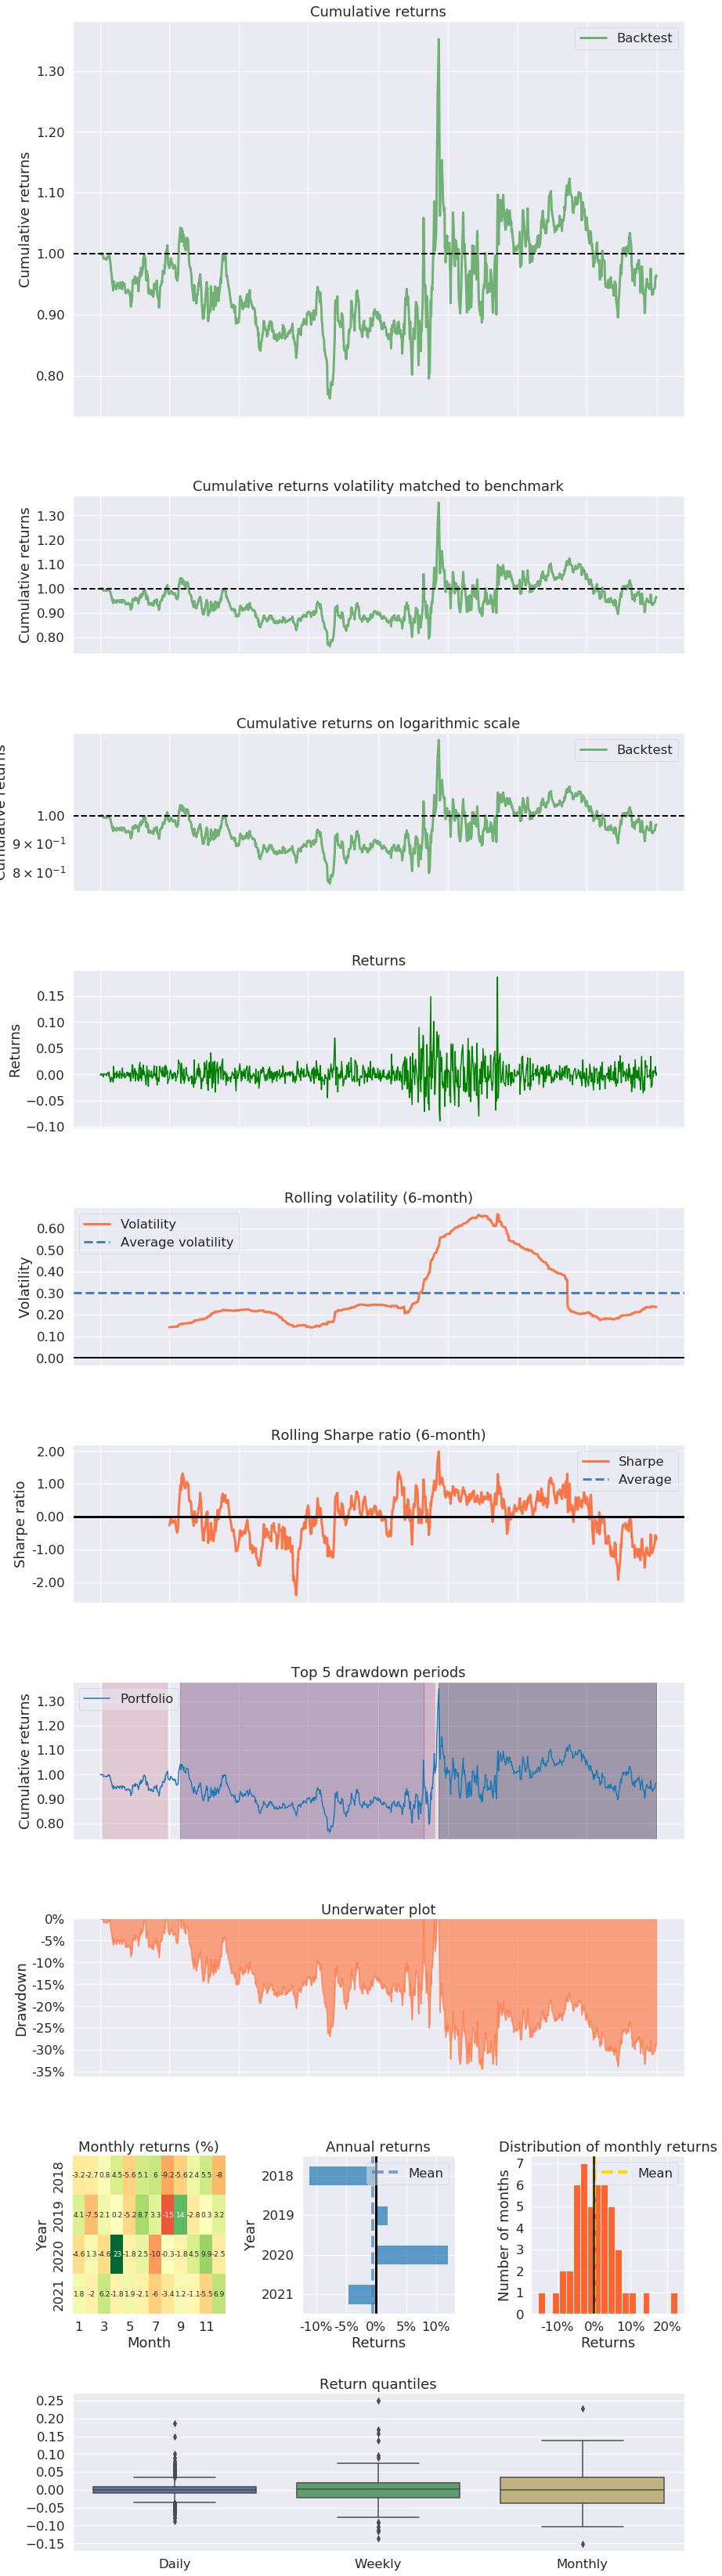

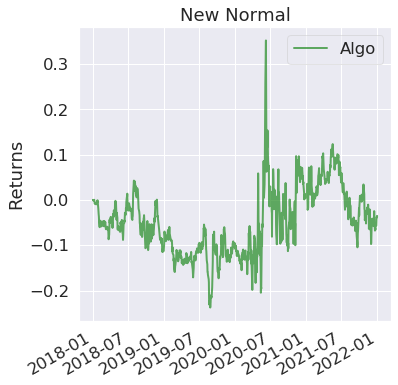

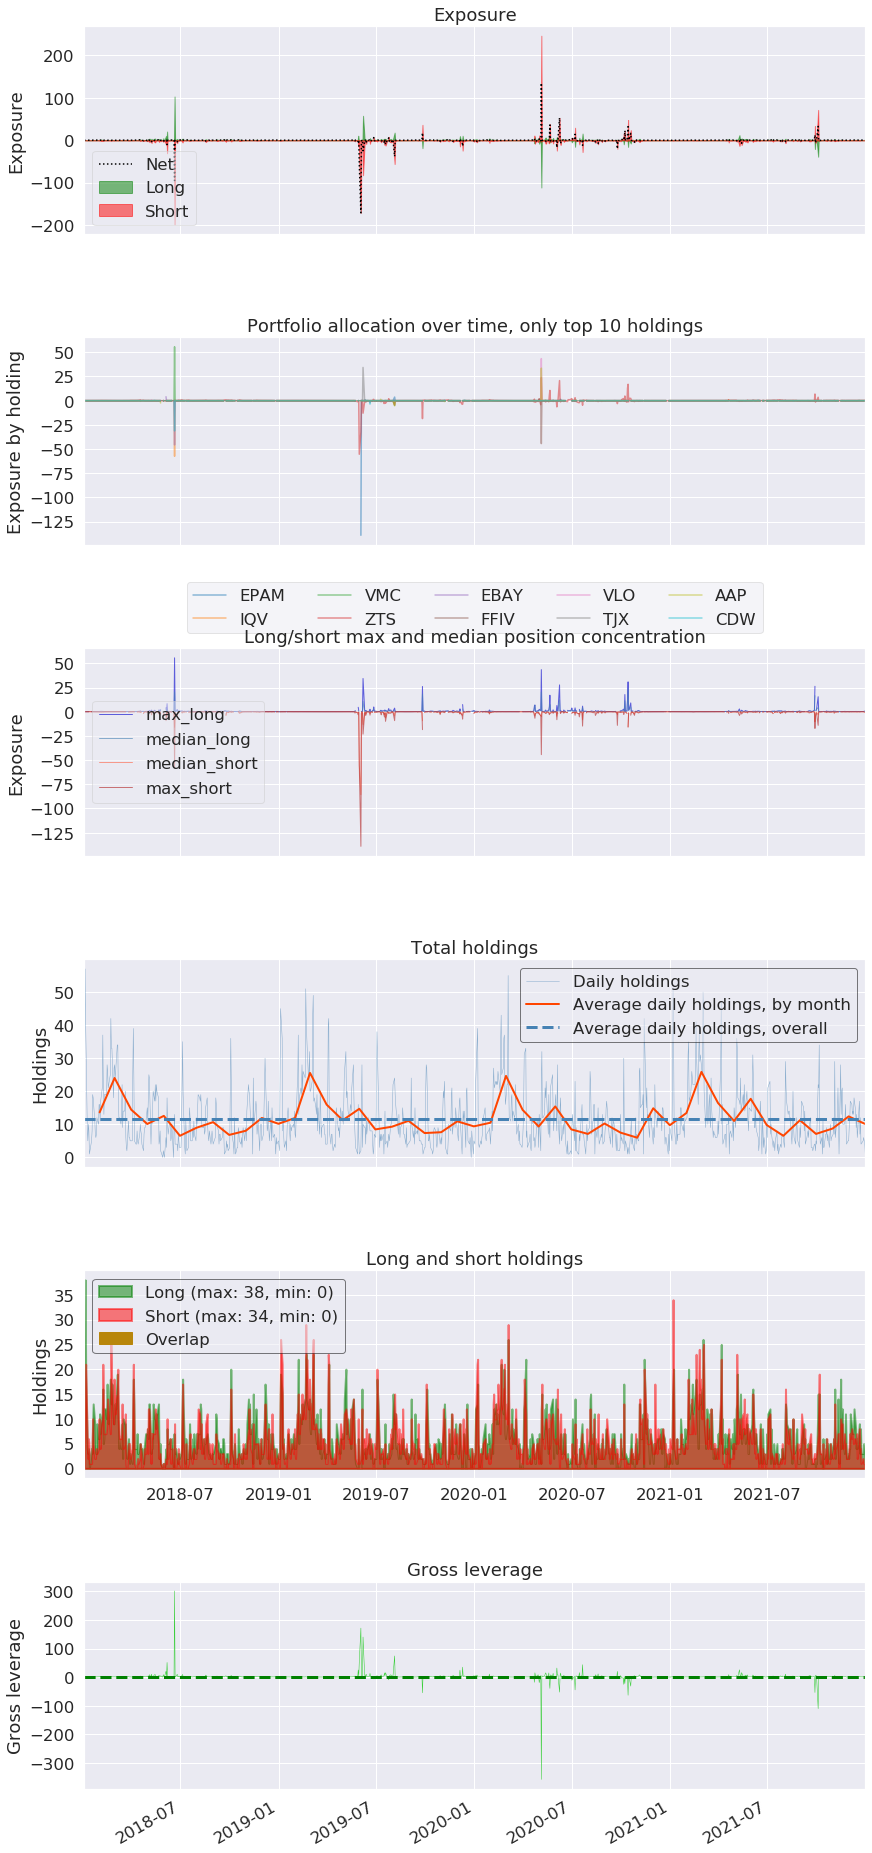

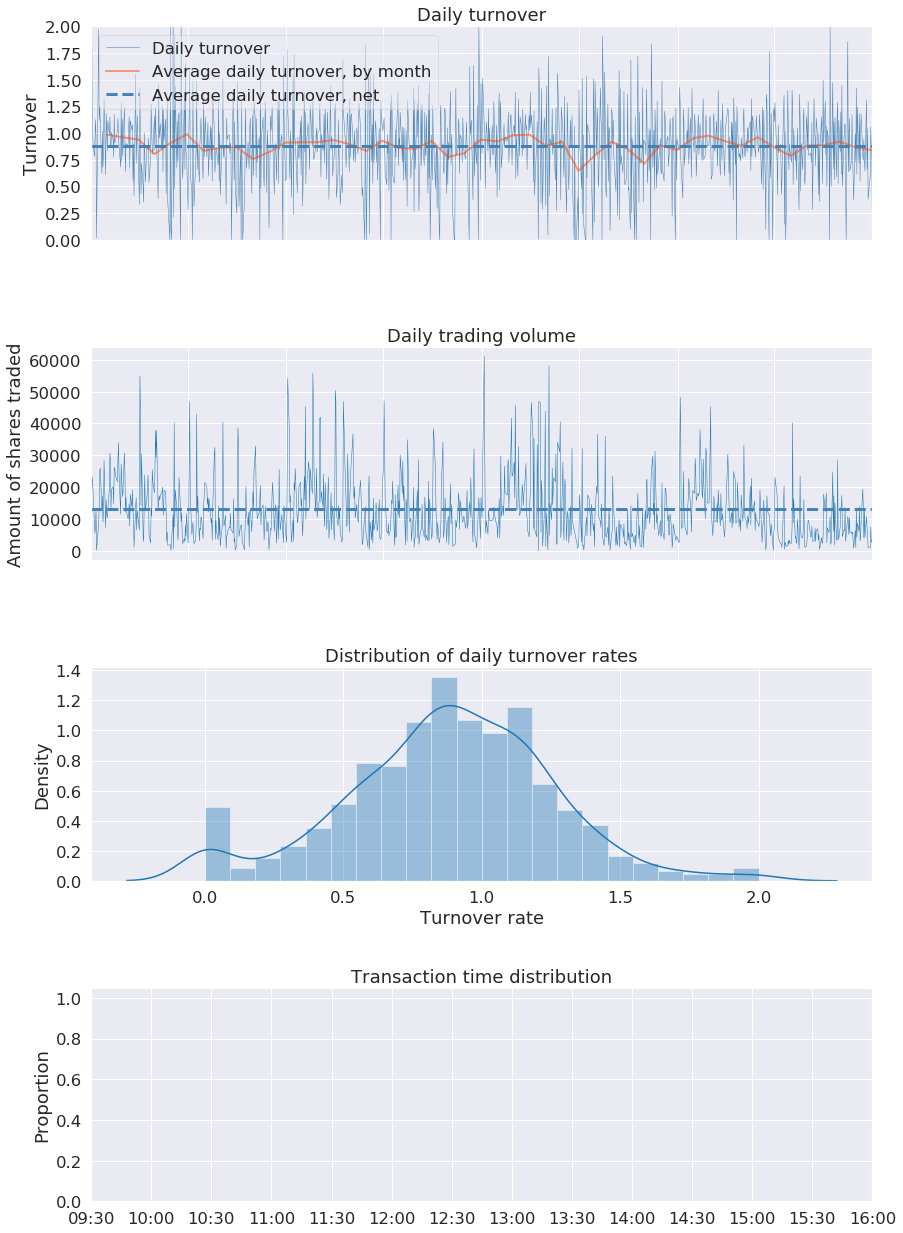

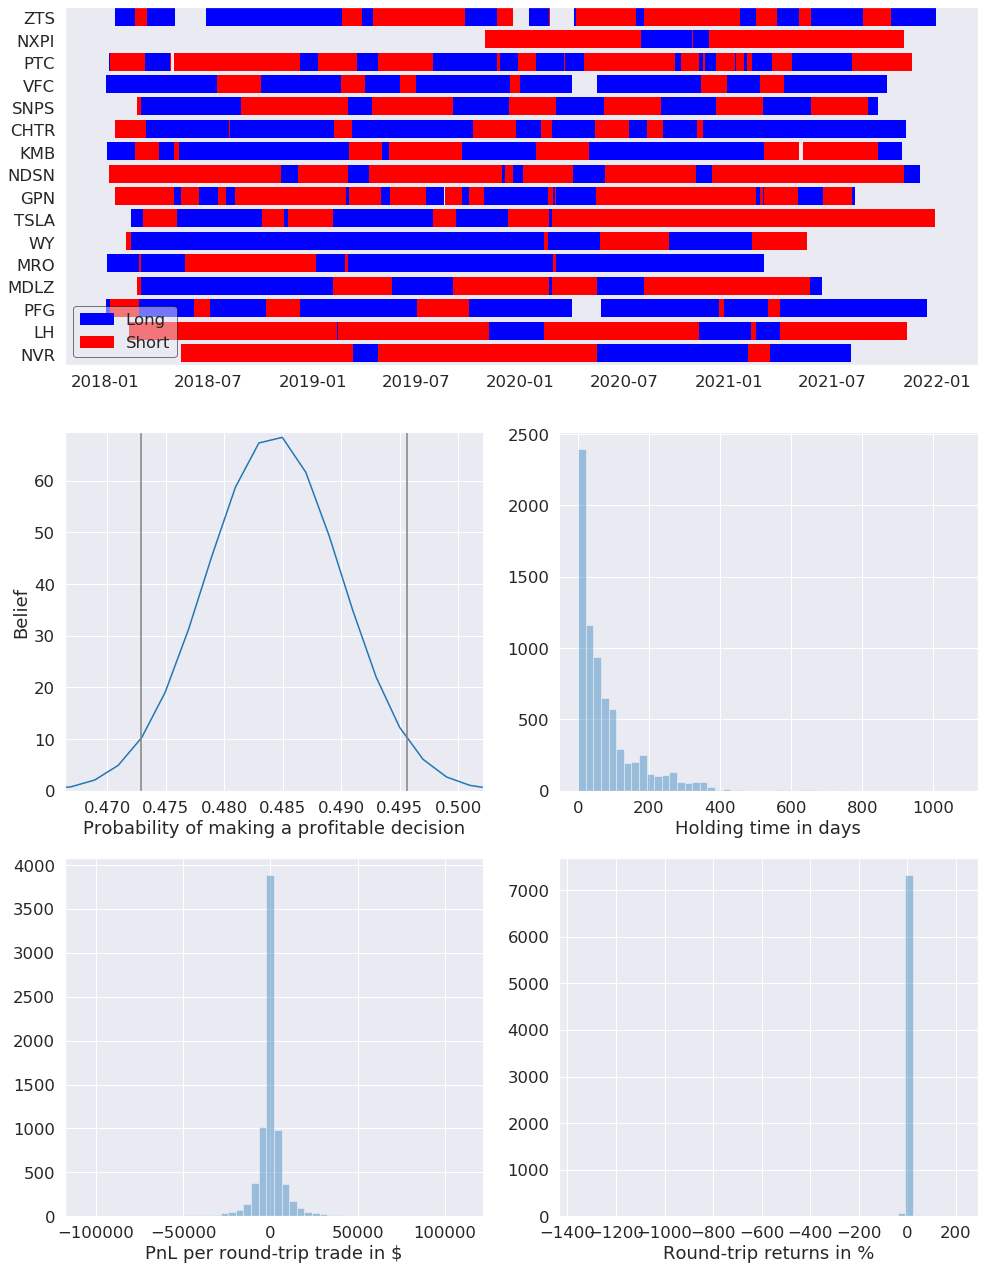

In [39]:
%matplotlib inline
import pyfolio as pf
pyfoliozer = strats[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
pf.create_full_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions,
    # live_start_date='2005-05-01',  # This date is sample specific
    round_trips=True)